# Step 1: create a sine signal with frequency 10 Hz

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def sine_function(x, amplitude, frequency, phase):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

# Step 2: One BPM signal simple sine and perturbed

10000 10000


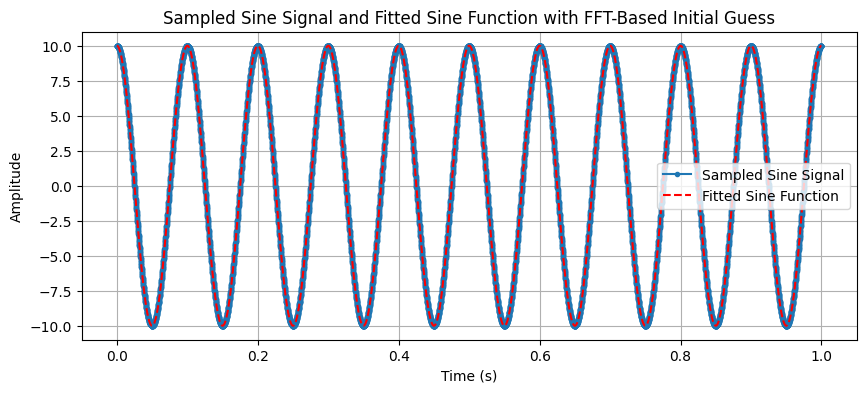

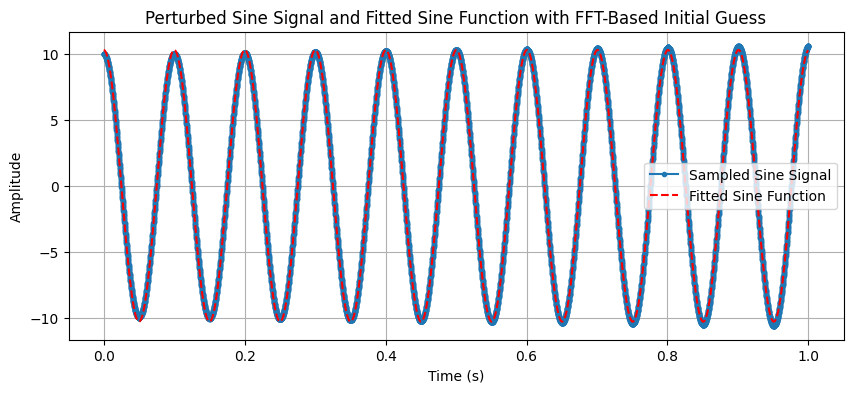

In [3]:
# Define parameters
sample_rate = 10000  # Sampling rate (samples per second)
duration = 1.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
phase=np.pi/2

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi/4.
new_frequency = 10.0
new_signal_noise = 0.05*np.sin(2 * np.pi * new_frequency * t + new_phase)

sine_signal_broken = sine_signal.copy()
print(len(sine_signal_broken), len(sine_signal))
for i in range(len(t)):
    if i%550 == 0 and not i==0:
        sine_signal_broken[i:] += new_signal_noise[i:]

# Calculate the FFT of the signal
fft_result = np.fft.fft(sine_signal)
fft_result_broken = np.fft.fft(sine_signal_broken)

# Extract the dominant frequency from the FFT
dominant_frequency = np.argmax(np.abs(fft_result)) / duration
dominant_frequency_broken = np.argmax(np.abs(fft_result_broken)) / duration

# Define the sine function to fit
def sine_function(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi)

# Use the FFT-based estimate for the initial guess, with the correct amplitude
initial_guess = [amplitude, dominant_frequency, 0]
initial_guess_broken = [amplitude, dominant_frequency, 0]
#print(initial_guess)

# Fitting the sine function to the sampled data
fit_params, _ = curve_fit(sine_function, t, sine_signal, p0=initial_guess)
fit_params_broken, _ = curve_fit(sine_function, t, sine_signal_broken, p0=initial_guess)

# Plot the original sine function and the fitted sine function
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal, label='Sampled Sine Signal', marker='.')
plt.plot(t, sine_function(t, fit_params[0], fit_params[1], fit_params[2]), c='r', label='Fitted Sine Function', linestyle='--')
plt.title('Sampled Sine Signal and Fitted Sine Function with FFT-Based Initial Guess')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
# Plot the broken sine function and the fitted sine function
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal_broken, label='Sampled Sine Signal', marker='.')
plt.plot(t, sine_function(t, fit_params_broken[0], fit_params_broken[1], fit_params_broken[2]), c='r', label='Fitted Sine Function', linestyle='--')
plt.title('Perturbed Sine Signal and Fitted Sine Function with FFT-Based Initial Guess')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()


# Step 3: Multiple BPMs with a simple sine oscillation and two kick applied close to each other

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


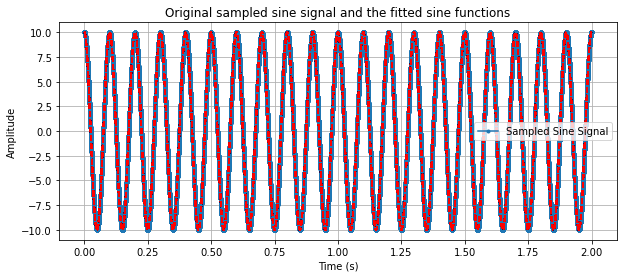

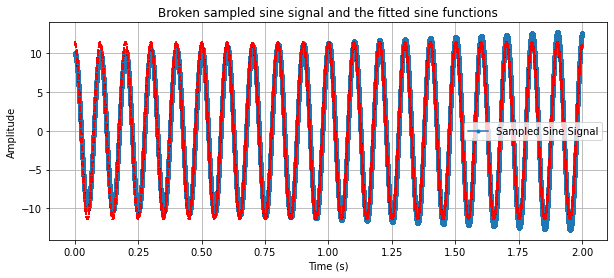

100


In [4]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

phase = np.pi/2

# Define parameters
sample_rate = 100000  # Sampling rate (samples per second)
duration = 2.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
phases_all = []
phases_all_broken = []

# Generate time values#
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi/4.
new_frequency = 10.0
new_signal_noise = 0.005*np.sin(2 * np.pi * new_frequency * t + new_phase)
sine_signal_broken = sine_signal.copy()

for i in range(len(t)):
    if i%550 == 0 and not i==0:
        sine_signal_broken[i+40:] += new_signal_noise[i+40:]
        sine_signal_broken[i+45:] += new_signal_noise[i+45:]
        
# Define the sine function to fit
def sine_function(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi) 

# Fit a sine function to every other point spaced 550 points apart (BPMs)
fit_params_list = []
fit_params_list_broken = []

for i in range(100):
    t_subset = t[i + 1*550::550]                                                    # Important to take every BPM osc separately
    sine_signal_subset = sine_signal[i + 1*550::550]
    #plt.plot(t_subset, sine_signal_subset)
    sine_signal_subset_broken = sine_signal_broken[i + 1*550::550]                  # Starting after the first turn, where the beam is excited already

    # Calculate the FFT of the signal
    fft_result = np.fft.fft(sine_signal_subset)
    fft_result = fft_result / len(fft_result) * 2
    fft_result_broken = np.fft.fft(sine_signal_subset_broken)
    fft_result_broken = fft_result_broken / len(fft_result_broken) * 2
    myfreqs = np.fft.fftfreq(len(fft_result), d=t_subset[1] - t_subset[0])
    myfreqs_broken = np.fft.fftfreq(len(fft_result_broken), d=t_subset[1] - t_subset[0])

    # Extract the dominant frequency and phase from the FFT
    idx = np.argmax(abs(fft_result))
    guess_amplitude = abs(fft_result)[idx]
    guess_frequency = myfreqs[idx]
    guess_phase = np.angle(fft_result[idx])

    idx_broken = np.argmax(abs(fft_result_broken))
    guess_amplitude_broken = abs(fft_result_broken)[idx_broken]
    guess_frequency_broken = myfreqs_broken[idx_broken]
    guess_phase_broken = np.angle(fft_result_broken[idx_broken])

    initial_guess = [guess_amplitude, guess_frequency, guess_phase]
    initial_guess_broken = [guess_amplitude_broken, abs(guess_frequency_broken), abs(guess_phase_broken)]

    fit_params, _ = curve_fit(sine_function, t_subset, sine_signal_subset, p0=initial_guess)
    fit_params_list.append(fit_params)

    fit_params_broken, _ = curve_fit(sine_function, t_subset, sine_signal_subset_broken, p0=initial_guess_broken)
    fit_params_list_broken.append(fit_params_broken)

# Generate the fitted sine functions for visualization
fitted_signals = []
fitted_signals_broken = []

for fit_params in fit_params_list:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals.append(fitted_signal)
    phases_all.append(fit_params[2])
    
for fit_params in fit_params_list_broken:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals_broken.append(fitted_signal)
    phases_all_broken.append(fit_params[2])
    
# Plot the original sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals:
    plt.plot(t, fitted_signal, linestyle='--', color = 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.title('Original sampled sine signal and the fitted sine functions')

# Plot the broken sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal_broken, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals_broken:
    plt.plot(t, fitted_signal, linestyle='--', c = 'red')
plt.title('Broken sampled sine signal and the fitted sine functions')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
print(len(fit_params_list))

# Phase break detection at the two locations - BPM 40 and BPM 45

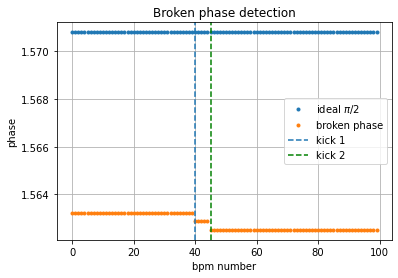

In [5]:
#plt.figure(figsize=(16,9))
plt.plot(np.round(np.array(phases_all)%np.pi, 7), '.', label = 'ideal $\pi/2$')
plt.plot(np.round(np.array(phases_all_broken)%np.pi, 7),'.', label = 'broken phase') 
plt.xlabel('bpm number')
plt.ylabel('phase')
plt.title('Broken phase detection')
plt.grid(True)
plt.axvline(x = 40, linestyle = '--', label = 'kick 1')
plt.axvline(x = 45, linestyle = '--',color = 'g', label = 'kick 2')
plt.legend()

## This is the phase we put in $\pi/2$  and breaking of the phase 
Even though the fit is not perfectly fitting the amplitude the phase detection works. In the real case we don't have this extreme case.


## Now, we need to combine the BPMs and fit them simultaneously
    - Add the phase advance knowledge to the sine
    

In [235]:
1/sample_rate

1e-05

In [242]:
1/550.*1./sample_rate

1.818181818181818e-08

In [347]:
#np.diff(time_all[:,0])

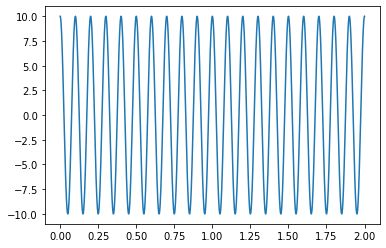

In [348]:
plt.plot(t, sine_signal)

In [6]:
Tturn = 1/sample_rate*num_bpm

1e-05


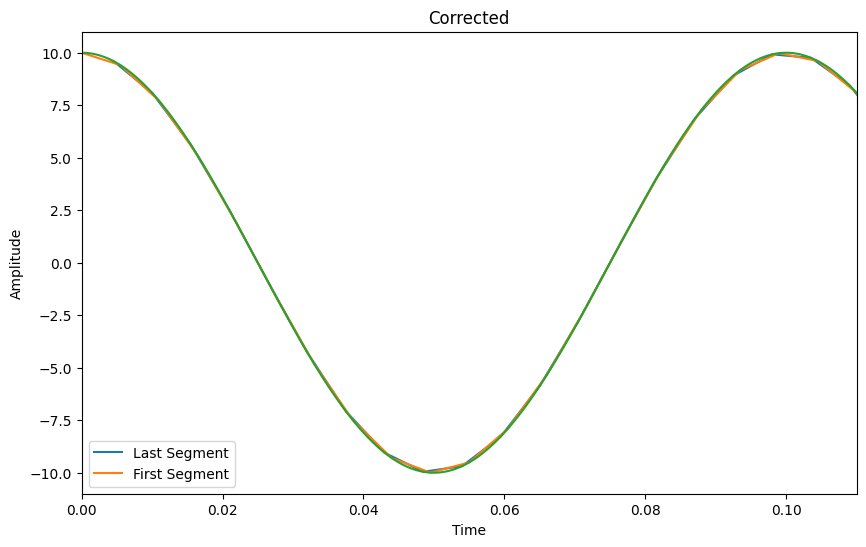

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
sample_rate = 100000  # Sampling rate (samples per second)
duration = 2.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
phase = np.pi / 2
num_bpm = 550

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

t_bpm = np.sort(t)[:550]
dt = duration / int(sample_rate * duration)
print(dt)
s = np.linspace(0, 27000, num_bpm, endpoint=False)
dt_new = []
dtnew = 0
'''
# For the real case
for i in range(len(s)):
    dtnew = 0
    ds = s[i] - s[0]
    dt = ds / light
    dtnew += dt
    dt_new.append(dtnew)
'''
# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi / 4.
new_frequency = 10.0
new_signal_noise = 0.01 * np.sin(2 * np.pi * new_frequency * t + new_phase)
num_turn = len(sine_signal[0::num_bpm])

# Define the sine function to fit
def sine_function(t, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * t + phi) + offset

# Create lists to store data
t_all = []
bpm_turn = []
time_all = []

for i in range(num_bpm):
    time_all.append(t[i::num_bpm])
    #time_all.append([(turn) / sample_rate + t_bpm[i] / num_bpm for turn in range(num_turn)]) #question: why do we need the /num_bpm
    t_subset = t[i::num_bpm]
    sine_signal_subset = sine_signal[i::num_bpm]
    t_all.append(t_subset.tolist())
    bpm_turn.append(np.array(sine_signal_subset))                                   #here is the matrix bpm x turn number

#transposed_matrix = [list(row) for row in zip(*bpm_turn)]
#two_d_array = [char for char in bpm_turn]
#print(np.array(two_d_array).shape)
#bpm_turn = np.array(two_d_array)
#two_d =  [char for char in time_all]
#time_all = np.array(two_d)
bpm_turn = np.array([list(i) for i in zip(*bpm_turn)]).T
bpm_turn.shape
time_all = np.array([list(i) for i in zip(*time_all)]).T
#bpm_turn.shape


plt.figure(figsize=(10, 6))

#for i in np.arange(0, min(551, num_bpm), 100):
 #   plt.plot(time_all[i][:362], bpm_turn[i][:362])

plt.plot(time_all[-100,:], bpm_turn[-100,:], label='Last Segment')
plt.plot(time_all[0,:], bpm_turn[0,:], label='First Segment')
plt.plot(t, sine_signal)

plt.xlim(0, Tturn*20)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Corrected')
plt.show()


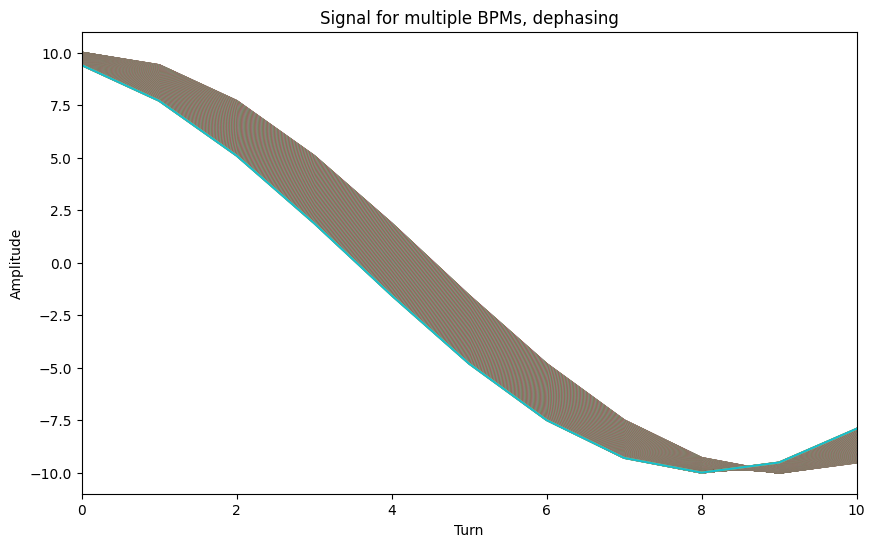

In [8]:
plt.figure(figsize = (10,6))
for i in range(len(bpm_turn)):
    plt.plot(bpm_turn[i])
    plt.xlim(0,10)
    plt.ylabel('Amplitude')
    
    plt.xlabel('Turn')
    plt.title('Signal for multiple BPMs, dephasing')

In [365]:
import scipy

corrected_all = []
corrected_bpm_all = []

#for i in range(len(bpm_turn)):
bpm_idx = [0,-50,-1]
#for i in range(len(bpm_turn)):
bpm_idx = [0,200,-1]

cc = ['k', "b", "g"]
for i in bpm_idx:
    fourier = scipy.fft.fft(bpm_turn[i])
    #fourier = fourier / len(fourier) * 2
    freqs = np.linspace(0, 1./Tturn, len(fourier))
    #freqs = np.fft.fftfreq(len(fourier), 1./sample_rate)#np.linspace(0, sample_rate, len(fourier))
    #print(time_all[i,0])
    #print(fourier[0:10])
    corrected_signal =fourier * np.exp(-2 * np.pi * freqs * (time_all[i,0]) *1j)
    #corrected_bpm = np.array(bpm_turn[i]) * np.exp(-1j * 2 * np.pi * frequency * t_bpm[i]) 
    
    corrected_all.append(corrected_signal)
    #print(corrected_signal[0:10])
    #print()>
    #corrected_bpm_all.append(corrected_bpm)
#print(frequency)

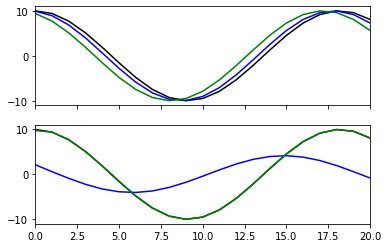

In [366]:
fig, ax = plt.subplots(nrows = 2, sharex = True, sharey = True)

#for i in range(len(corrected_all)):
for (counter, i),myc in zip(enumerate(bpm_idx), cc):
    plt.sca(ax[0])
    back_trafo = scipy.fft.ifft(corrected_all[counter])
    #plt.plot(corrected_bpm_all[i])
    plt.plot(bpm_turn[i], color=myc)
    #plt.plot(bpm_turn[-1])
    plt.sca(ax[1])
    plt.plot(back_trafo,color=myc)
    plt.xlim(0,20)
    


In [251]:
#transposed_corrected = [list(row) for row in zip(*corrected_all)]

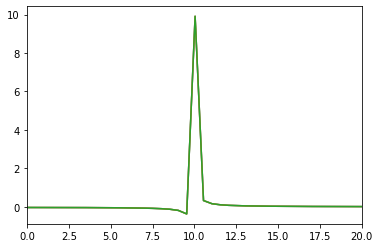

In [344]:
for i in range(len(corrected_all)):
    #plt.plot(corrected_all[i])
    plt.plot(freqs, np.fft.fft(bpm_turn[i][:363])/len(np.fft.fft(bpm_turn[i][:363]))*2)
    freqs

    plt.xlim(0,20)

# The signals are not aligned, why?

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

phase = np.pi/2

# Define parameters
sample_rate = 100000  # Sampling rate (samples per second)
duration = 2.0  # Duration in seconds
frequency = 10  # Frequency of the sine wave (Hz)
amplitude = 10  # Amplitude of the sine wave
num_bpm = 550
phases_all = []
phases_all_broken = []

# Generate time values#
t = np.linspace(0, duration, int(sample_rate * duration))
dt = duration/int(sample_rate * duration)



# Generate a sampled sine function
sine_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)

# Break the signal via kick
new_phase = np.pi/4.
new_frequency = 10.0
new_signal_noise = 0.005*np.sin(2 * np.pi * new_frequency * t + new_phase)
sine_signal_broken = sine_signal.copy()

for i in range(len(t)):
    if i%num_bpm == 0 and not i==0:
        sine_signal_broken[i+40:] += new_signal_noise[i+40:]
        sine_signal_broken[i+45:] += new_signal_noise[i+45:]
        
# Define the sine function to fit
def sine_function(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi) 

# Fit a sine function to every other point spaced 550 points apart (BPMs)
fit_params_list = []
fit_params_list_broken = []
sine_signal_2D = []
t_subset_all = []

for i in range(num_bpm):
    t_subset = t[i + 1*num_bpm::num_bpm] - t[i + 1 * num_bpm] + i * dt                   # Important to take every BPM osc separately         
    sine_signal_subset = sine_signal[i + 1 * num_bpm::num_bpm]
    
    #plt.plot(t_subset, sine_signal_subset)
    #plt.xlim(0,0.1)


for i in range(100):
    t_subset = t[i + 1*num_bpm::num_bpm]                                                    # Important to take every BPM osc separately
    t_subset_all.append(t_subset)
    sine_signal_subset = sine_signal[i + 1*num_bpm::num_bpm]
    #print(t_subset[0] - (i) * dt - t[num_bpm])
    #plt.plot(t_subset, sine_signal_subset)
    sine_signal_subset_broken = sine_signal_broken[i + 1*num_bpm::num_bpm]                  # Starting after the first turn, where the beam is excited already
    sine_signal_subset = np.sin(2 * np.pi * frequency * (t_subset - i * dt - t[num_bpm]) + phase) # corrected the signals, extended them to start form 0 for all the BPMs
    sine_signal_2D.append(sine_signal_subset)
    
    # Calculate the FFT of the signal
    fft_result = np.fft.fft(sine_signal_subset)
    fft_result = fft_result / len(fft_result) * 2
    fft_result_broken = np.fft.fft(sine_signal_subset_broken)
    fft_result_broken = fft_result_broken / len(fft_result_broken) * 2
    myfreqs = np.fft.fftfreq(len(fft_result), d=t_subset[1] - t_subset[0])
    myfreqs_broken = np.fft.fftfreq(len(fft_result_broken), d=t_subset[1] - t_subset[0])
    
    #plt.plot(t_subset, sine_signal_subset)
    #plt.show()
    
    '''
    # Extract the dominant frequency and phase from the FFT
    idx = np.argmax(abs(fft_result))
    guess_amplitude = abs(fft_result)[idx]
    guess_frequency = myfreqs[idx]
    guess_phase = np.angle(fft_result[idx])

    idx_broken = np.argmax(abs(fft_result_broken))
    guess_amplitude_broken = abs(fft_result_broken)[idx_broken]
    guess_frequency_broken = myfreqs_broken[idx_broken]
    guess_phase_broken = np.angle(fft_result_broken[idx_broken])

    initial_guess = [guess_amplitude, guess_frequency, guess_phase]
    initial_guess_broken = [guess_amplitude_broken, abs(guess_frequency_broken), abs(guess_phase_broken)]

    fit_params, _ = curve_fit(sine_function, t_subset, sine_signal_subset, p0=initial_guess)
    fit_params_list.append(fit_params)

    fit_params_broken, _ = curve_fit(sine_function, t_subset, sine_signal_subset_broken, p0=initial_guess_broken)
    fit_params_list_broken.append(fit_params_broken)

# Generate the fitted sine functions for visualization
fitted_signals = []
fitted_signals_broken = []

for fit_params in fit_params_list:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals.append(fitted_signal)
    phases_all.append(fit_params[2])
    
for fit_params in fit_params_list_broken:
    fitted_signal = sine_function(t, fit_params[0], fit_params[1], fit_params[2])
    fitted_signals_broken.append(fitted_signal)
    phases_all_broken.append(fit_params[2])
    
# Plot the original sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals:
    plt.plot(t, fitted_signal, linestyle='--', color = 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.title('Original sampled sine signal and the fitted sine functions')

# Plot the broken sampled sine signal and the fitted sine functions
plt.figure(figsize=(10, 4))
plt.plot(t, sine_signal_broken, label='Sampled Sine Signal', marker='.')
for fitted_signal in fitted_signals_broken:
    plt.plot(t, fitted_signal, linestyle='--', c = 'red')
plt.title('Broken sampled sine signal and the fitted sine functions')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()
print(len(fit_params_list))
'''

In [3]:
curve_fit(sine_function, t_subset_all, sine_signal_2D)

ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.

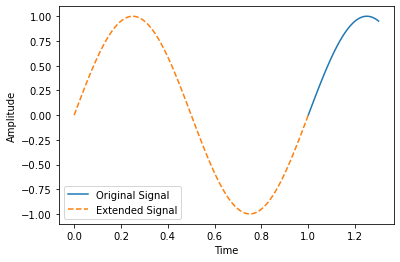

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Given arrays for t and y on the interval [1, 1.3]
t_original = np.linspace(1, 1.3, 100)
y_original = np.sin(2 * np.pi * t_original)

# Phase shift to extend the signal to [0, 1]
t_extended = np.linspace(0, 1, 100)
y_extended = np.sin(2 * np.pi * (t_extended - 1))

# Plotting the original and extended signals
plt.plot(t_original, y_original, label='Original Signal')
plt.plot(t_extended, y_extended, label='Extended Signal', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()



In [15]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#%%

revolution_frequency = 11245.5  # Hz
observation_points_per_turn = 550
desired_frequency = 1000.0 

# Calculate the time for one complete turn
turn_duration = 1 / revolution_frequency

num_turns = 10000

# Time
t = np.linspace(0, turn_duration*num_turns, observation_points_per_turn*num_turns, endpoint=False)

# BPMs
bpms = np.arange(1, observation_points_per_turn+1)

# BPM names
bpms_names = [f"bpm_{i}" for i in bpms.tolist()]

# Repeat for all turns
bpms_names = np.tile(bpms_names, num_turns)

# Turns
turns = np.repeat(np.arange(num_turns), observation_points_per_turn)

# Phase
phase = np.pi/4.

signal = 10.0*np.sin(2 * np.pi * desired_frequency * t + phase)

#%%
# Create a dictionary to store the data
data_dict = {'Turn': turns, 'BPM': bpms_names, 'Time': t,  'Signal': signal}
#data_dict['Signal']

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data_dict)
import numpy as np
import pandas as pd


# Identify the indices where BPM 5 occurs in the DataFrame
bpm_5_indices = df[df['BPM'] == 'bpm_5'].index

# Define the sine oscillation parameters
perturbation_frequency = 10.0  # Frequency of the sine oscillation
perturbation_amplitude = 2.0  # Amplitude of the sine oscillation

# Loop through BPM 5 indices and propagate perturbation forward and backward
for idx in bpm_5_indices:
    time_at_bpm_5 = df.at[idx, 'Time']
    current_turn = df.at[idx, 'Turn']
    
    # Propagate the perturbation to subsequent BPMs on the same turn after BPM 5
    next_bpm_same_turn_indices = df[(df['Turn'] == current_turn) & (df.index > idx) & (df['BPM'] != 'bpm_5')].index
    for next_idx in next_bpm_same_turn_indices:
        time_difference = df.at[next_idx, 'Time'] - time_at_bpm_5
        phase_shift_forward = 2 * np.pi * perturbation_frequency * time_difference
        propagation_forward = perturbation_amplitude * np.sin(phase_shift_forward)
        
        # Add the propagated perturbation forward to subsequent BPMs on the same turn
        df.at[next_idx, 'Signal'] += propagation_forward
    
    # Propagate the perturbation to previous BPMs on the next turn before BPM 5
    next_turn = current_turn + 1
    prev_bpm_next_turn_indices = df[(df['Turn'] == next_turn) & (df.index < idx) & (df['BPM'] != 'bpm_5')].index[::-1]
    for prev_idx in prev_bpm_next_turn_indices:
        time_difference = time_at_bpm_5 - df.at[prev_idx, 'Time']
        phase_shift_backward_next_turn = 2 * np.pi * perturbation_frequency * time_difference
        propagation_backward_next_turn = perturbation_amplitude * np.sin(phase_shift_backward_next_turn)
        
        # Add the propagated perturbation backward to previous BPMs on the next turn
        df.at[prev_idx, 'Signal'] += propagation_backward_next_turn

# Continue with your analysis or plotting to observe perturbation propagation in both directions




# Include noise
phase_noise = np.pi/4
indices = df[data_dict['BPM'] == f'bpm_{bpms[-1]}']['Signal'].index
print(indices)


myturn=3700
plt.plot(df[df["Turn"] == myturn-1]["Time"],df[df["Turn"] == myturn-1]["Signal"], c='k', lw=15)
plt.plot(t,signal, c='lime')
plt.xlim((myturn-1)*turn_duration, myturn*turn_duration)
# %%

# Pivot the DataFrame to have columns as the unique 550 observation points and rows as the data of each observation at each turn
df_time = df.pivot(index='Turn', columns='BPM', values='Time')

noise = 4* np.sin(2 * np.pi * desired_frequency *  df_time[f'bpm_{bpms[-1]}'].values + phase_noise)
#df.loc[indices, 'Signal'] += noise



# Pivot the DataFrame to have columns as the unique 550 observation points and rows as the data of each observation at each turn
df_bpm_turn = df.pivot(index='Turn', columns='BPM', values='Signal')

df_bpm_turn = df_bpm_turn.reindex(sorted(df_bpm_turn.columns, key=lambda x: int(x.split("_")[1])), axis=1)

print(df)
print(df_bpm_turn)
df_time = df_time.reindex(sorted(df_bpm_turn.columns, key=lambda x: int(x.split("_")[1])), axis=1)

print(df_time)
# %%
#signal = 10.0*np.sin(2 * np.pi * desired_frequency * t + phase)


# Loop over bpms and plot the signal for each bpm


# %%


KeyboardInterrupt: 

/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: 

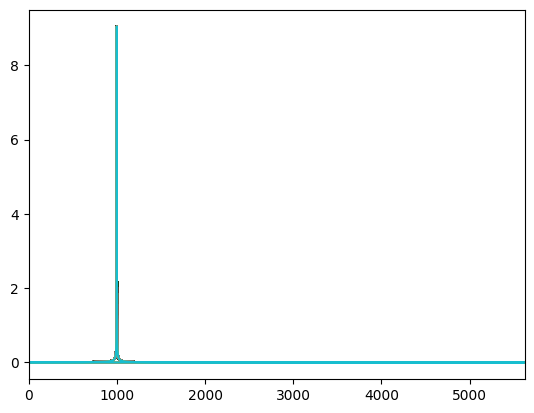

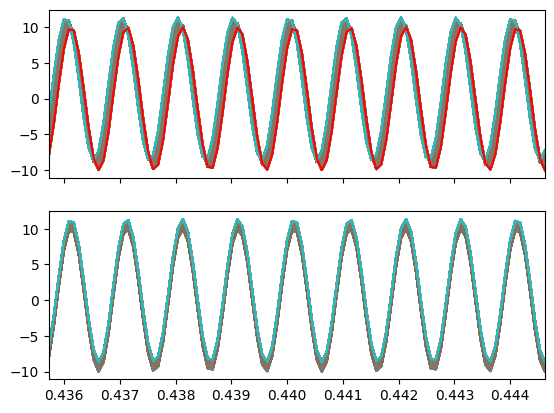

In [16]:
fig,ax = plt.subplots(nrows=2, sharex=True)
fig2, ax2 = plt.subplots()
df_corrected = pd.DataFrame()
for bpm in bpms:
    #plt.plot(df_time[f"bpm_{bpm}"], df_bpm_turn[f"bpm_{bpm}"], label=f"BPM {bpm}")
    plt.sca(ax[0])
    plt.plot(df_time[f"bpm_1"], df_bpm_turn[f"bpm_{bpm}"], label=f"BPM {bpm}")

    
    plt.sca(ax2)
    current_fourier = np.fft.fft(df_bpm_turn[f"bpm_{bpm}"].values)
    current_fourier = current_fourier/len(current_fourier) *2.
    #freqs = np.linspace(0, revolution_frequency, len(current_fourier)-1)
    freqs = np.fft.fftfreq(len(current_fourier), 1 / revolution_frequency)
    plt.xlim(0, 0.5*revolution_frequency)
    plt.plot(freqs, abs(current_fourier))
    Dt = df_time[f"bpm_{bpm}"].loc[0]
    corrected_fourier = current_fourier*np.exp(-1j*2.0*np.pi*freqs*Dt)
    corrected_signal = np.fft.ifft(corrected_fourier)
    corrected_signal = corrected_signal*len(corrected_signal)/2.
    plt.sca(ax[1])
    plt.plot(df_time[f"bpm_1"], corrected_signal, label=f"BPM {bpm}")
    #print(len(corrected_signal))
    df_corrected[f'corrected_signal_bpm_{bpm}'] = corrected_signal
    df_corrected[f'time{bpm}'] = df_time[f"bpm_1"]
    
    
plt.sca(ax[0])
plt.xlim(turn_duration*4900,turn_duration*5000)
plt.plot(df_time[f"bpm_1"], df_bpm_turn[f"bpm_5"], label=f"BPM {5}", color = 'r')


In [17]:
df_corrected

,corrected_signal_bpm_1,time1,corrected_signal_bpm_2,time2,corrected_signal_bpm_3,time3,corrected_signal_bpm_4,time4,corrected_signal_bpm_5,time5,...,corrected_signal_bpm_546,time546,corrected_signal_bpm_547,time547,corrected_signal_bpm_548,time548,corrected_signal_bpm_549,time549,corrected_signal_bpm_550,time550
0,7.071068+0.000000j,0.000000,7.078409-0.000001j,0.000000,7.085753-0.000002j,0.000000,7.093099-0.000004j,0.000000,7.100447-0.000005j,0.000000,...,8.698061+0.000005j,0.000000,8.693730+0.000004j,0.000000,8.689397+0.000003j,0.000000,8.685063+0.000002j,0.000000,8.680729+0.000001j,0.000000
1,9.744203+0.000000j,0.000089,9.741310+0.000001j,0.000089,9.738425+0.000002j,0.000089,9.735549+0.000004j,0.000089,9.732681+0.000005j,0.000089,...,11.112764-0.000005j,0.000089,11.112926-0.000004j,0.000089,11.113047-0.000003j,0.000089,11.113126-0.000002j,0.000089,11.113163-0.000001j,0.000089
2,9.453730-0.000000j,0.000178,9.455447-0.000001j,0.000178,9.457157-0.000002j,0.000178,9.458860-0.000004j,0.000178,9.460555-0.000005j,0.000178,...,10.803167+0.000005j,0.000178,10.807035+0.000004j,0.000178,10.810921+0.000003j,0.000178,10.814824+0.000002j,0.000178,10.818746+0.000001j,0.000178
3,6.287992+0.000000j,0.000267,6.286787+0.000001j,0.000267,6.285589+0.000002j,0.000267,6.284396+0.000004j,0.000267,6.283209+0.000005j,0.000267,...,7.649911-0.000005j,0.000267,7.651342-0.000004j,0.000267,7.652761-0.000003j,0.000267,7.654168-0.000002j,0.000267,7.655564-0.000001j,0.000267
4,1.209820-0.000000j,0.000356,1.210743-0.000001j,0.000356,1.211661-0.000002j,0.000356,1.212575-0.000004j,0.000356,1.213484-0.000005j,0.000356,...,2.562568+0.000005j,0.000356,2.565794+0.000004j,0.000356,2.569028+0.000003j,0.000356,2.572270+0.000002j,0.000356,2.575519+0.000001j,0.000356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-4.541896-0.000000j,0.888800,-4.541141+0.000001j,0.888800,-4.540393+0.000002j,0.888800,-4.539650+0.000004j,0.888800,-4.538914+0.000005j,0.888800,...,-3.188465-0.000005j,0.888800,-3.185368-0.000004j,0.888800,-3.182267-0.000003j,0.888800,-3.179162-0.000002j,0.888800,-3.176053-0.000001j,0.888800
9996,0.871557+0.000000j,0.888889,0.870622-0.000001j,0.888889,0.869694-0.000002j,0.888889,0.868775-0.000004j,0.888889,0.867864-0.000005j,0.888889,...,2.232395+0.000005j,0.888889,2.234029+0.000004j,0.888889,2.235658+0.000003j,0.888889,2.237282+0.000002j,0.888889,2.238900+0.000001j,0.888889
9997,6.019935-0.000000j,0.888978,6.021161+0.000001j,0.888978,6.022376+0.000002j,0.888978,6.023579+0.000004j,0.888978,6.024771+0.000005j,0.888978,...,7.371306-0.000005j,0.888978,7.374811-0.000004j,0.888978,7.378323-0.000003j,0.888978,7.381840-0.000002j,0.888978,7.385363-0.000001j,0.888978
9998,9.337405-0.000000j,0.889067,9.335642-0.000001j,0.889067,9.333897-0.000002j,0.889067,9.332171-0.000004j,0.889067,9.330464-0.000005j,0.889067,...,10.701839+0.000005j,0.889067,10.702760+0.000004j,0.889067,10.703672+0.000003j,0.889067,10.704576+0.000002j,0.889067,10.705473+0.000001j,0.889067


## Define the lists one uses for the time and the bpm data

BPM      bpm_1     bpm_2     bpm_3     bpm_4     bpm_5     bpm_6     bpm_7  \
Turn                                                                         
0     7.071068  7.078247  7.085420  7.092585  7.099743  7.109433  7.119115   
1     9.744203  9.746481  9.748749  9.751007  9.753255  9.758032  9.762799   
2     9.453730  9.450413  9.447087  9.443751  9.440405  9.439589  9.438764   
3     6.287992  6.280090  6.272181  6.264266  6.256344  6.250955  6.245560   
4     1.209820  1.199735  1.189649  1.179562  1.169474  1.161924  1.154373   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -4.541896 -4.532843 -4.523786 -4.514724 -4.505657 -4.494046 -4.482430   
9996  0.871557  0.881677  0.891796  0.901913  0.912030  0.924686  0.937341   
9997  6.019935  6.028044  6.036146  6.044242  6.052332  6.062955  6.073573   
9998  9.337405  9.341037  9.344659  9.348271  9.351873  9.358006  9.364129   
9999  9.814990  9.813040  9.811080  9.809110  9.807129  9.807678

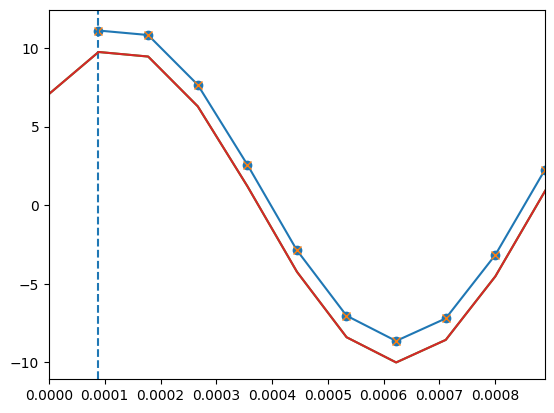

In [18]:
print(df_bpm_turn)
list_bpm = [df_bpm_turn[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
list_time = [df_time[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
print(list_bpm)
len(list_bpm)
#plt.plot(list_bpm[-1]-df_bpm_turn[f'bpm_{bpms[-1]}'].values)
plt.plot(df_time[f'bpm_{bpms[-1]}'].values, df_bpm_turn[f'bpm_{bpms[-1]}'].values, '-o')
plt.plot(list_time[-1], list_bpm[-1], 'x')
plt.axvline(x = list_time[-1][0], linestyle = '--')
plt.xlim(0, 10/revolution_frequency)
plt.plot(df_time[f'bpm_{bpms[0]}'].values, df_bpm_turn[f'bpm_{bpms[0]}'].values)
plt.plot(list_time[0], list_bpm[0])

/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


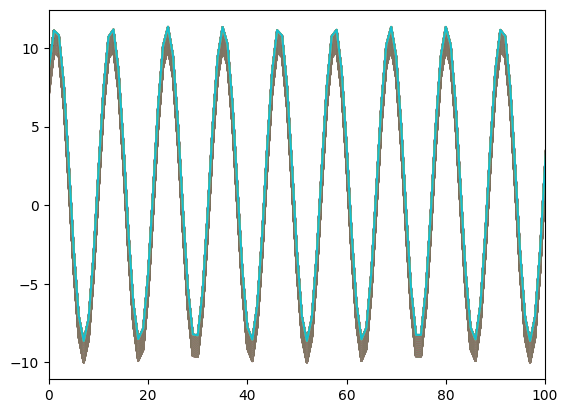

In [19]:
#plt.plot(df.loc[indeces, 'Signal'])
#plt.xlim(0,10000)
for i in range(len(bpms)):
    plt.plot(df_corrected[f'corrected_signal_bpm_{bpms[i]}'].values)
    plt.xlim(0,100)
    

## Simple solving of the equations without the DSn parameter

(550, 10000)
[9.045689333067102, 999.7249499999999, -0.017002174070641616]


/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [ 4.29543787e-06+1.24824314e-09j
               -3.21181758e-04+1.50714501e-10j ...
                1.36734725e+00+1.06676168e-06j
                1.36362458e+00-1.06738078e-06j]
           x: [1.00004302e+01+3.28173760e-10j
               1.00000002e+03+3.64613432e-11j
               7.85354538e-01-2.09326036e-10j]
        cost: (1718978.0607863814-0.004764535989682658j)
         jac: [[-7.071e-01  0.000e+00 -7.072e+00]
               [-9.744e-01 -1.256e-03 -2.248e+00]
               ...
               [-9.338e-01 -1.999e+01 -3.579e+00]
               [-9.815e-01  1.070e+01  1.916e+00]]
        grad: [0.00025605-1.13721062e-09j 0.00845534-3.08623485e-09j
               0.00106144-2.67149760e-08j]
  optimality: 0.008455343784078759
 active_mask: [0.+0.j 0.+0.j 0.+0.j]
        nfev: 14
        njev: 10
A = (10.000430211862794+3.2817375968849806e-10j), f = (1000.000

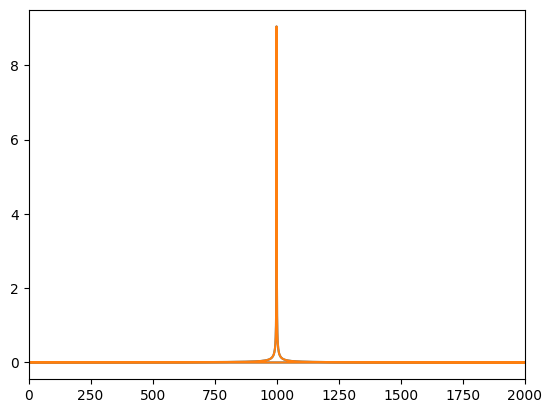

In [20]:
from scipy.optimize import least_squares
import numpy as np
import scipy
# Define the error function for the system of equations without phase break!!
def error_function(params, t, *signals):
    A, f, phase = params
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    #print(np.mean([signal - model_signals for signal in signals], axis = 1).shape)
    return np.concatenate([signal - model_signals for signal in signals])
    #return np.mean([signal - model_signals for signal in signals], axis = 1)

# df_corrected is my DataFrame containing the signals and time data
signals =  [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
print(np.array(signals).shape)

# Apply function use u=insead of the list
#df_corrected.apply(lambda x: print(x), axis = 0)
#df_corrected.drop(columns = ['time'])

fft_result = scipy.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

initial_guess =  [guess_amplitude, guess_frequency, guess_phase]  # In
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, *signals))                # Pass the signals that we 

# Extract the optimized parameters
A_opt, f_opt, phase_opt = result.x
print(result)

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt)))%np.pi}")
plt.plot(freqs, abs(fft_result))

plt.xlim(0,2000)
old_fft = abs(np.fft.fft(df_bpm_turn[f"bpm_1"].values))
old_fft = old_fft/len(old_fft)*2.
plt.plot(freqs, old_fft)

## Without correcting for the dephasing, and passing the whole t

(550, 10000)
[9.045689333067102, 999.7249499999999, -0.017002174070641616]


     message: Both `ftol` and `xtol` termination conditions are satisfied.
     success: True
      status: 4
         fun: [ 1.366e+00  1.365e+00 ...  1.366e+00  1.367e+00]
           x: [ 1.000e+01  1.000e+03  7.852e-01]
        cost: 9336.78885576984
         jac: [[-9.741e-01 -1.260e-03 -2.260e+00]
               [-9.458e-01  3.627e-03  3.248e+00]
               ...
               [-9.817e-01  1.065e+01  1.907e+00]
               [-7.313e-01  3.811e+01  6.821e+00]]
        grad: [ 1.006e-06  7.297e-07  7.642e-06]
  optimality: 7.642309164168637e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 14
        njev: 10
A = 10.000665371135508, f = 1000.0000739262299, phase = 0.7851738229631239


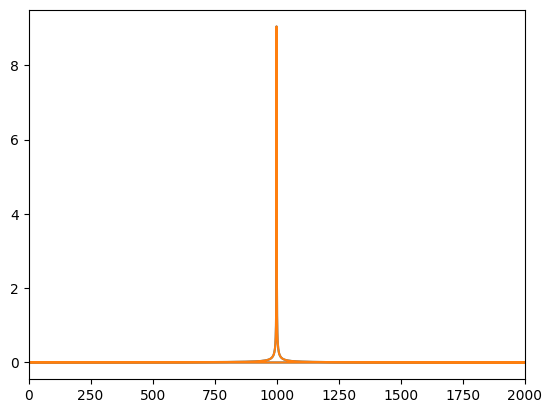

In [21]:
from scipy.optimize import least_squares
import numpy as np
import scipy
# Define the error function for the system of equations without phase break!!
result_new = []
def error_function(params, t, signals):
    A, f, phase = params
    for i in range(len(signals)):
        model_signals = A * np.sin(2 * np.pi * f * t[i] + phase)
        result = signals [i] - model_signals
        result_new = np.concatenate([result])
    #print(np.mean([signal - model_signals for signal in signals], axis = 1).shape)
    return result_new #np.concatenate([signal - model_signals for signal in signals])
    #return np.mean([signal - model_signals for signal in signals], axis = 1)

# df_corrected is my DataFrame containing the signals and time data
signals = list_bpm #[df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
list_bpm = [df_bpm_turn[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
list_time = [df_time[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
print(np.array(signals).shape)

# Apply function use u=insead of the list
#df_corrected.apply(lambda x: print(x), axis = 0)
#df_corrected.drop(columns = ['time'])

fft_result = scipy.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = list_time
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

initial_guess =  [guess_amplitude, guess_frequency, guess_phase]  # In
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, signals))                # Pass the signals that we 

# Extract the optimized parameters
A_opt, f_opt, phase_opt = result.x
print(result)

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt)))%np.pi}")
plt.plot(freqs, abs(fft_result))

plt.xlim(0,2000)
old_fft = abs(np.fft.fft(df_bpm_turn[f"bpm_1"].values))
old_fft = old_fft/len(old_fft)*2.
plt.plot(freqs, old_fft)

(550, 10000)
[9.045689333067102, 999.7249499999999, -0.017002174070641616, 0.0]


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-5.560e-13  6.111e-13 ...  5.613e-13  5.103e-12]
           x: [ 1.000e+01  1.000e+03  7.854e-01  1.367e+00]
        cost: 3.6726399347762014e-20
         jac: [[-9.742e-01 -1.259e-03 -2.257e+00 -1.000e+00]
               [-9.457e-01  3.629e-03  3.250e+00 -1.000e+00]
               ...
               [-9.817e-01  1.064e+01  1.905e+00 -1.000e+00]
               [-7.314e-01  3.810e+01  6.819e+00 -1.000e+00]]
        grad: [ 3.467e-10 -1.226e-07 -4.046e-08 -7.737e-11]
  optimality: 1.2264524018434634e-07
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
        nfev: 14
        njev: 10
A = 10.000000000000075, f = 999.9999999999998, phase = 0.7853981633976598, DSn = 1.3665133439128496


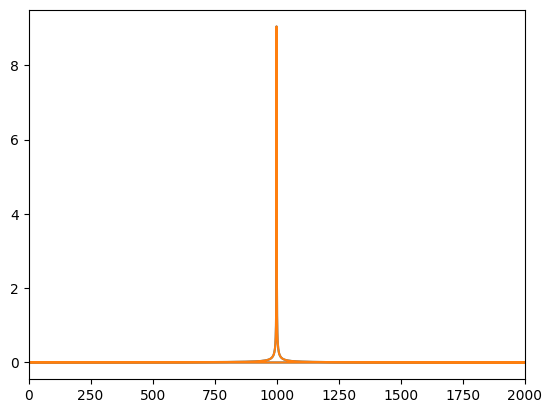

In [22]:
from scipy.optimize import least_squares
import numpy as np
import scipy
# Define the error function for the system of equations without phase break!!
result_new = []
def error_function(params, t, signals):
    A, f, phase, DSn = params
    for i in range(len(signals)):
        model_signals = A * np.sin(2 * np.pi * f * t[i] + phase)
        if i == len(signals) - 1:
            result = signals[i] - DSn - model_signals
        #elif i == len(signals) - 2:
        #    result = signals[i] -  DSn2 - model_signals
        else:
            result = signals[i] - model_signals
    
        result_new = np.concatenate([result])
    #print(np.mean([signal - model_signals for signal in signals], axis = 1).shape)
    return result_new #np.concatenate([signal - model_signals for signal in signals])
    #return np.mean([signal - model_signals for signal in signals], axis = 1)

# df_corrected is my DataFrame containing the signals and time data
signals = list_bpm #[df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
list_bpm = [df_bpm_turn[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
list_time = [df_time[f'bpm_{bpms[i]}'].values for i in range(0, len(bpms))]
print(np.array(signals).shape)

# Apply function use u=insead of the list
#df_corrected.apply(lambda x: print(x), axis = 0)
#df_corrected.drop(columns = ['time'])

fft_result = scipy.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = list_time
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

initial_guess =  [guess_amplitude, guess_frequency, guess_phase, 0.0]  # In
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, signals))                # Pass the signals that we 

# Extract the optimized parameters
A_opt, f_opt, phase_opt, DSn_opt= result.x
print(result)

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt)))%np.pi}, DSn = {DSn_opt}")
plt.plot(freqs, abs(fft_result))

plt.xlim(0,2000)
old_fft = abs(np.fft.fft(df_bpm_turn[f"bpm_1"].values))
old_fft = old_fft/len(old_fft)*2.
plt.plot(freqs, old_fft)

In [23]:
# One parameter in the last equation

from scipy.optimize import least_squares
import numpy as np
import scipy
# Define the error function for the system of equations without phase break!!
result_new = []
def error_function(params, t, signals):
    A, f, phase, *DSn = params
    for i in range(len(signals)):
        model_signals = A * np.sin(2 * np.pi * f * t[i] + phase)
        #if i == len(signals) - 1:
        #    result = signals[i] - np.sum(DSn[:i]) - model_signals
        #elif i == len(signals) - 2:
        #    result = signals[i] -  DSn2 - model_signals
        #else:
        #    result = signals[i] - model_signals
    
        result = signals[i] + DSn[i] - model_signals
    
        result_new = np.concatenate([result])
    #print(np.mean([signal - model_signals for signal in signals], axis = 1).shape)
    return result_new #np.concatenate([signal - model_signals for signal in signals])
    #return np.mean([signal - model_signals for signal in signals], axis = 1)

# df_corrected is my DataFrame containing the signals and time data
signals = np.array(list_bpm) #[df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
print(signals.dtype)

# Apply function use u=insead of the list
#df_corrected.apply(lambda x: print(x), axis = 0)
#df_corrected.drop(columns = ['time'])

fft_result = scipy.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = np.array(list_time)
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

initial_guess =  [guess_amplitude, guess_frequency, guess_phase] + [0.]*len(signals) # In
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, signals))                # Pass the signals that we 

# Extract the optimized parameters
A_opt, f_opt, phase_opt, DSn_opt= result.x
print(result)

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt)))%np.pi}", f"DSn = {DSn_opt}")
plt.plot(freqs, abs(fft_result))

plt.xlim(0,2000)
old_fft = abs(np.fft.fft(df_bpm_turn[f"bpm_1"].values))
old_fft = old_fft/len(old_fft)*2.
plt.plot(freqs, old_fft)

float64
[9.045689333067102, 999.7249499999999, -0.017002174070641616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

ValueError: too many values to unpack (expected 4)

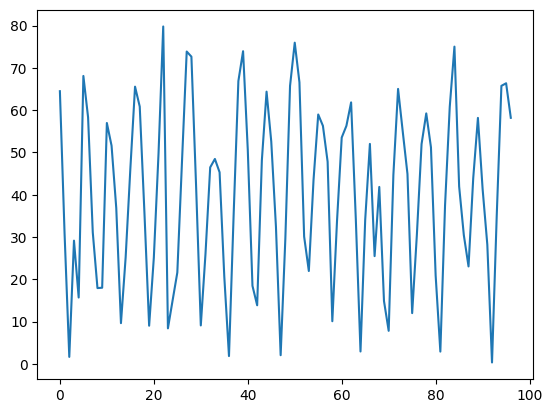

In [29]:
plt.plot(abs(result.x[3:100]))

In [78]:
np.array(len(bpms)*[0.0]).dtype

dtype('float64')

## Simple solving of the equations with one DSn parameter at the last equation

In [11]:
from scipy.optimize import least_squares
import numpy as np

# Define the error function for the system of equations with Delta signal
def error_function(params, t, *signals):
    A, f, phase, DSn = params  # Unpack the parameters, including DSn
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    results = []
    #counter = 0
    for i, signal in enumerate(signals):
        #counter+=1
        if i == len(signals)-1:
            #print('last')
            result = signal + DSn - model_signals
        else:
            result = signal - model_signals
        results.append(result)
    #print(counter)
    return np.concatenate(results)

# df_corrected is the DataFrame containing the signals and time data
signals = [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 

fft_result = np.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])


# Set initial guesses for parameters A, f, phase, and DSn
initial_guess = [guess_amplitude, guess_frequency, guess_phase] + [0.1] #* (len(bpms) - 1)
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, *signals))

# Extract the optimized parameters
A_opt, f_opt, phase_opt, DSn_opt = result.x

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt))) % np.pi}")
print(f"DSn = {DSn_opt}")


[9.0456893330671, 999.7249499999999, -0.017002174070641616, 0.1]
A = (10.0001011704114+3.2815024691119574e-10j), f = (999.9999871766989+3.6467407924868834e-11j), phase = 0.7854466302411431
DSn = (-2.4355361675657566e-05+2.539966300679422e-13j)


In [25]:
from scipy.optimize import least_squares
import numpy as np

# Define the error function for the system of equations with Delta signal
def error_function(params, t, *signals):
    A, f, phase, DSn, DSn2 = params  # Unpack the parameters, including DSn
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    results = []
    #counter = 0
    for i, signal in enumerate(signals):
        #counter+=1
        if i == len(signals)-1:
            #print('last')
            result = signal + DSn + DSn2 - model_signals
        elif i == len(signals)-2:
            #print('last')
            result = signal + DSn2 - model_signals
        else:
            result = signal - model_signals
            
        results.append(result)
    #print(counter)
    return np.concatenate(results)

# df_corrected is the DataFrame containing the signals and time data
signals = [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 

fft_result = np.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
fft_result = fft_result/len(fft_result)*2.
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])


# Set initial guesses for parameters A, f, phase, and DSn
initial_guess = [guess_amplitude, guess_frequency, guess_phase, 0.0, 0.0] #* (len(bpms) - 1)
print(initial_guess)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, *signals))

# Extract the optimized parameters
A_opt, f_opt, phase_opt, DSn_opt, DSn_opt2 = result.x

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt))) % np.pi}")
print(f"DSn = {DSn_opt, DSn_opt2}")


[9.0456893330671, 999.7249499999999, -0.017002174070641616, 0.0, 0.0]


/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


A = (10.000101170389241+3.281502606556788e-10j), f = (999.9999871766964+3.6467318324571436e-11j), phase = 0.7854466302472258
DSn = ((6.602863264316405e-07-1.5375606853751408e-22j), (-2.5015647986565688e-05+2.539960087281569e-13j))


## Simple solving of the equations with a DSn parameter for all equations

In [ ]:
from scipy.optimize import least_squares
import numpy as np

# Define the error function for the system of equations with Delta signal in multiple equations
def error_function(params, t, *signals):
    A, f, phase, *DSn = params  # Unpack the parameters, including DSn
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    results = []
    for i, signal in enumerate(signals):
        result = signal + np.sum(DSn[:i, :], all)- model_signals
        results.append(result)
    return np.concatenate(results)

# df_corrected is the DataFrame containing the signals and time data
signals = [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
fft_result = np.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

# Set initial guesses for parameters A, f, phase, and DSn
initial_guess = [guess_amplitude, guess_frequency, guess_phase] + [0.0] * (len(bpms) - 1)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, *signals))

# Extract the optimized parameters
A_opt, f_opt, phase_opt, *DSn_opt = result.x

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt))) % np.pi}")
print(f"DSn = {DSn_opt}")


In [ ]:
from scipy.optimize import least_squares
import numpy as np

# Define the error function for the system of equations with Delta signal in multiple equations
def error_function(params, t, *signals):
    A, f, phase, *DSn = params  # Unpack the parameters, including DSn
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    results = []
    for i, signal in enumerate(signals):
        result = signal + DSn[i - 1] - model_signals
        results.append(result)
    return np.concatenate(results)

# df_corrected is the DataFrame containing the signals and time data
signals = [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 
fft_result = np.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])

# Set initial guesses for parameters A, f, phase, and DSn
initial_guess = [guess_amplitude, guess_frequency, guess_phase] + [0.0] * (len(bpms) - 1)

# Perform the optimization
result = least_squares(error_function, initial_guess, args=(t, *signals))

# Extract the optimized parameters
A_opt, f_opt, phase_opt, *DSn_opt = result.x

print(f"A = {A_opt}, f = {f_opt}, phase = {np.array(abs(np.array(phase_opt))) % np.pi}")
print(f"DSn = {DSn_opt}")


In [ ]:
len(signals[0])

In [ ]:
from scipy.optimize import least_squares
import numpy as np

counter = 0
# Define the error function for the system of equations
# Initialize a variable to hold the result for bpm_550 separately
result_bpm_550 = None

def error_function(params, t, *signals):
    global counter, result_bpm_550
    
    counter += 1
    A, f, phase, dsn = params
    model_signals = A * np.sin(2 * np.pi * f * t + phase)
    
    if counter != bpms[-1]:
        result = np.concatenate([signal - model_signals for signal in signals])
    else: 
        result_bpm_550 = np.concatenate([signal + dsn - model_signals for signal in signals])
        if counter == 550:
            result = result_bpm_550  # Store the result for bpm_550
    return result

# df_corrected is my DataFrame containing the signals and time data
signals =  [df_corrected[f'corrected_signal_bpm_{i}'].values for i in range(1, len(bpms) + 1)] 

fft_result = scipy.fft.fft(df_corrected['corrected_signal_bpm_1'].values)
t = df_corrected['time1'].values  # Assuming a common time column for all signals
idx = np.argmax(abs(fft_result))
guess_amplitude = abs(fft_result)[idx]
guess_frequency = freqs[idx]
guess_phase = np.angle(fft_result[idx])
guess_dsn = 1
initial_guesses =  [guess_amplitude, guess_frequency, guess_phase, guess_dsn]  # In
# Initial guesses for parameters A, f, phase

#initial_guess = [10.0, 1000.0, np.pi/2]  # Change these to initial values
print(initial_guesses)
# Perform the optimization
result = least_squares(error_function, initial_guesses, args=(t, *signals))

# Extract the optimized parameters
A_opt, f_opt, phase_opt , dsn_opt= result.x

print(f"A = {A_opt}, f = {f_opt}, phase = {phase_opt}, dsn = {dsn_opt}")


In [ ]:
print(abs(phase_opt)%np.pi - np.pi/2)
abs(A_opt)